# Emotion Measure Validation

This notebook takes the Amazon Turk data and computes the validation metrics.

There are two steps. First is the pilot. Second is the complete validation task.

In [ ]:
# Packages
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Load colab packages
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# First pilot wihtout BERT
  # df_pilot = pd.read_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Final/Validation/Batch_5108437_batch_results.csv')

In [ ]:
df_pilot = pd.read_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Final/Validation/Batch_5111330_batch_results.csv')

In [ ]:
# Consistency check: unqiue worker per assignment
df_pilot.groupby('Input.text_bert')['WorkerId'].agg(lambda x: len(set(x))).reset_index()

In [ ]:
# Validation df
df_validation = pd.read_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Final/Validation/Batch_5111580_batch_results.csv')

In [ ]:
# Get df for fear control check
df_fear_check = pd.read_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Final/Validation/df_validation_fear_check.csv')

__Define functions to normalise and group the data from MTurk__


In [ ]:
# Normalise the answers, compute columns and summary columns
def normalise_answers(df_in, remove_checks=False):
  df = df_in.copy()

  # Normalise answers
  df['Answer.taskAnswers'] = df['Answer.taskAnswers'].apply(json.loads)
  df_normalized = pd.concat([pd.json_normalize(x) for x in df['Answer.taskAnswers'].apply(lambda x: x[0])], ignore_index=True)
  df_final = pd.concat([df.drop('Answer.taskAnswers', axis=1), df_normalized], axis=1)

  # Get attention checks
  df_final['Attention_check_test']= df_final.apply(lambda row: True if row['agree-t2.no'] == True and row['emotion2.hope'] == True else False, axis=1)
  df_final['Attention_check_nota1'] = np.where((df_final['agree-t1.yes'] == True) & (df_final['emotion1.notapplicable'] != True), False, True)
  df_final['Attention_check_nota3'] = np.where((df_final['agree-t2.yes'] == True) & (df_final['emotion2.notapplicable'] != True), False, True)

  if remove_checks:
    df_final = df_final[df_final['Attention_check_nota1'] == True]
    df_final = df_final[df_final['Attention_check_nota3'] == True]

  # get emotion label selected
  def get_emotion1(row):
    for column in df_final.columns:
        if "emotion1." in column and row[column] == True:
            return column
    return None

  def get_emotion2(row):
      for column in df_final.columns:
          if "emotion2." in column and row[column] == True:
              return column
      return None

  def get_emotion3(row):
      for column in df_final.columns:
          if "emotion3." in column and row[column] == True:
              return column
      return None

  df_final['emotion_t1'] = df_final.apply(get_emotion1, axis=1)
  df_final['emotion_t2'] = df_final.apply(get_emotion2, axis=1)
  df_final['emotion_t3'] = df_final.apply(get_emotion3, axis=1)

  df_final = df_final[['AssignmentId', 'WorkerId', 'WorkTimeInSeconds', 'feedback',
                       'Input.text_bert', 'Input.suggested_emotion_bert','agree-t1.yes', 'emotion_t1',
                       'Input.text_test', 'Input.suggested_emotion_test','agree-t2.yes', 'emotion_t2',
                       'Input.text_gpt', 'Input.suggested_emotion_gpt', 'agree-t3.yes', 'emotion_t3',
                       'Attention_check_test', 'Attention_check_nota1', 'Attention_check_nota3']]

  # get grouped df
  df_grouped_bert = df_final.groupby('Input.text_bert').agg({'agree-t1.yes': lambda x: x.astype(bool).sum(),
                                                             'Input.suggested_emotion_bert': max,
                                                             'emotion_t1': list}).reset_index()

  df_grouped_gpt = df_final.groupby('Input.text_gpt').agg({'agree-t3.yes': lambda x: x.astype(bool).sum(),
                                                          'Input.suggested_emotion_gpt': max,
                                                          'emotion_t3': list}).reset_index()

  #grouped = df_final.groupby('Input.text_gpt')['agree-t2.yes'].apply(lambda x: x.astype(bool).sum()).reset_index()
  def get_most_common(lst, number):
    count = Counter(lst)
    most_common = count.most_common(1)
    if most_common[0][1] == 1:
      return "uncertain"
    else:
      return most_common[0][0].replace(f'emotion{number}.', '')

  # Add final label colunm
  df_grouped_bert['final_label'] = df_grouped_bert.apply(
    lambda row: row['Input.suggested_emotion_bert'] if row['agree-t1.yes'] > 1
    else get_most_common(row['emotion_t1'], 1), axis=1)

  df_grouped_gpt['final_label'] = df_grouped_gpt.apply(
    lambda row: row['Input.suggested_emotion_gpt'] if row['agree-t3.yes'] > 1
    else get_most_common(row['emotion_t3'], 3), axis=1)


  return df_final, df_grouped_bert, df_grouped_gpt

In [ ]:
def summary(df_final, df_grouped, number='1', model='bert'): # df_final
  print('Fail attention test', df_final['Attention_check_test'].value_counts()[False])
  print('Fail attention nota1', df_final['Attention_check_nota1'].value_counts())
  print('Fail attention nota3', df_final['Attention_check_nota3'].value_counts())

  print(f'Accuracy {model}',df_grouped[df_grouped[f'agree-t{number}.yes'] > 1].shape[0] / df_grouped.shape[0])

  print('Disagreements:\n')
  for index, row in df_grouped.iterrows():
    if row[f'agree-t{number}.yes'] < 2:
      print(f"Text {index}: {row[f'Input.text_{model}'].strip()[:250]} \n",
            f"Suggested: {row[f'Input.suggested_emotion_{model}']}\n",
            f"N agree: {row[f'agree-t{number}.yes']} \n",
            f"Selected emotions: {row[f'emotion_t{number}']}")

In [ ]:
# OLD
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt

def confusion_matrix_show(df_grouped, model='gpt'):

    #df_grouped = df_grouped[df_grouped['final_label'] != 'uncertain']
    y_true = df_grouped['final_label']
    y_pred = df_grouped[f'Input.suggested_emotion_{model}']

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels = np.unique(np.concatenate((y_true, y_pred))))
    disp.plot(include_values=True,
              cmap='viridis', ax=None, xticks_rotation='vertical',
              values_format=None)

    # accuracy and f1
    f1 = f1_score(df_grouped['final_label'], df_grouped[f'Input.suggested_emotion_{model}'], average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy: {accuracy:.2f}, F1-score: {f1:.2f}")
    print('F1 weighted', f1_score(df_grouped['final_label'], df_grouped[f'Input.suggested_emotion_{model}'], average='weighted'), '\n',
          'F1 macro', f1_score(df_grouped['final_label'], df_grouped[f'Input.suggested_emotion_{model}'], average='macro'))
    # Set the title of the plot to include the accuracy
    plt.title(f'{model.capitalize()}\nAccuracy: {accuracy:.2f}, F1-score: {f1:.2f}')

    plt.tight_layout()
    #plt.savefig('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Images/confusion_matrix.png', dpi=300)
    #plt.show()

    # Calculate and print accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # classifiction reports
    report = classification_report(y_true, y_pred, output_dict=True)

    report_df = pd.DataFrame(report).transpose()

    # To latex and csome changes
    report_df_tex = report_df.to_latex()
    report_df_tex = report_df_tex.replace('\\toprule\n', '\\toprule\\toprule\n')
    report_df_tex = report_df_tex.replace('\\bottomrule\n', '\\bottomrule\\bottomrule\n')

    return disp, accuracy, f1
    #print(report_df_tex)
    # with open(f'/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/class_report_{model}.tex', 'w') as f:
    #   f.write(report_df_tex)

## Pilot

Pilot is performed on n=33, to cover each emotion three times. Additionally, I am testing a BERT model for validation comparison.


In [ ]:
df_final, df_pilot_bert, df_pilot_gpt = normalise_answers(df_pilot)

NameError: ignored

In [ ]:
summary(df_final, df_pilot_bert, number='1', model='bert')
summary(df_final, df_pilot_gpt, number='3', model='gpt')

Fail attention test 15
Fail attention nota1 True     96
False     3
Name: Attention_check_nota1, dtype: int64
Fail attention nota3 True    99
Name: Attention_check_nota3, dtype: int64
Accuracy  0.6666666666666666
Disagreements:

Text 0: A lot still needs to be done for our victory - and it is a difficult path, because the war continues - but already now we must do everything possible so that the aggressor loses not only on the battlefield, but also historically, conceptually... So t 
 Suggested: disgust
 N agree: 1 
 Selected emotions: ['emotion1.notapplicable', 'emotion1.notapplicable', 'emotion1.anger']
Text 2: During a meeting with Prime Minister of the United Kingdom Rishi Sunak, I noted the recent transfer of Storm Shadow long-range missiles to Ukraine. These are exactly the weapons we need today. They help us win. 

I informed him about the situation on 
 Suggested: fear
 N agree: 0 
 Selected emotions: ['emotion1.neutral', 'emotion1.neutral', 'emotion1.joy']
Text 5: I held a mee

In [ ]:
df_final[df_final['text_gpt']]

99

Accuracy: 0.67


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-130-c3edf2158459>:32: FutureWarning: In future ve

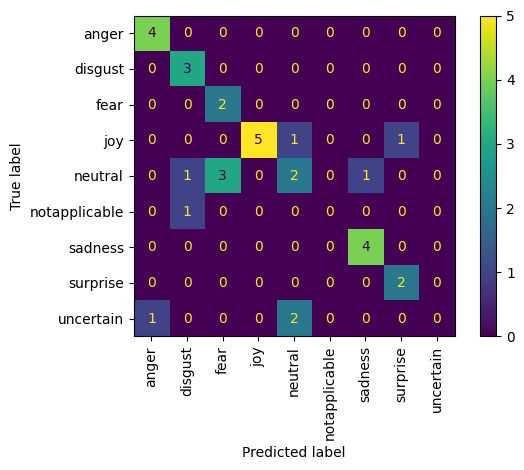

In [ ]:
confusion_matrix_show(df_pilot_bert, 'bert')

Accuracy: 0.82


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

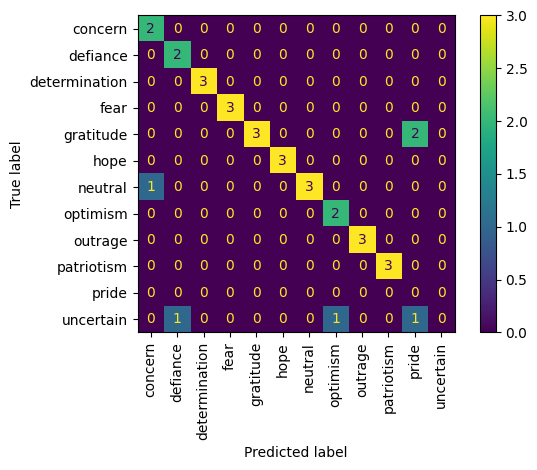

In [ ]:
b = confusion_matrix_show(df_pilot_gpt, 'gpt')

### Conclusions

There are several things we can learn from the pilot:

1. __Attention check__: too many people fail the attention check. In all but one cases the answer given was not hope but optimism. This indicates we should refine the definitions or task?

__Answer__: I refined the definition of hope and optimism. In case we have too many fails, we could stil argue people pay attenetion and selectd the very close emotion "optimism".

2. Feedback exmaples: som wish more examples.

__Answer__: I added an additional example for "emotion" and "hope".

3. Feedback List 1: does not have enough options.

__Answer__ This is somehow by purpose.

In [ ]:
df_final.columns


Index(['WorkTimeInSeconds', 'Input.text_bert', 'Input.suggested_emotion_bert',
       'agree-t1.yes', 'emotion_t1', 'Input.text_test',
       'Input.suggested_emotion_test', 'agree-t2.yes', 'emotion_t2',
       'Input.text_gpt', 'Input.suggested_emotion_gpt', 'agree-t3.yes',
       'emotion_t3', 'Attention_check_test', 'Attention_check_nota1',
       'Attention_check_nota3'],
      dtype='object')

In [ ]:
df_final[['feedback']]

,feedback
0,seemed easy enough
1,
2,Nothing was unclear.
3,Thank you.
4,
...,...
94,N/A
95,"For the first one, I feel like determination w..."
96,
97,Nothing was unclear.


# Validation


In [ ]:
df_val_final, df_val_bert, df_val_gpt = normalise_answers(df_validation, remove_checks=False)

In [ ]:
df_validation.shape[0] /3

270.0


Accuracy: 0.63, F1-score: 0.63
F1 weighted 0.6284304740745104 
 F1 macro 0.531038527601739
Accuracy: 0.63


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-29-1e05dbb4d57e>:43: FutureWarning: In future ver

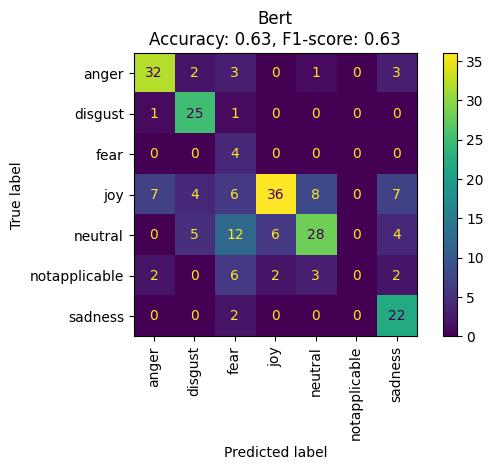

In [ ]:
bert_cm, bert_acc, bert_f1 = confusion_matrix_show(df_val_bert, 'bert')


Accuracy: 0.84, F1-score: 0.85
F1 weighted 0.8492834384732729 
 F1 macro 0.8279345482455619
Accuracy: 0.84


<ipython-input-29-1e05dbb4d57e>:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  report_df_tex = report_df.to_latex()


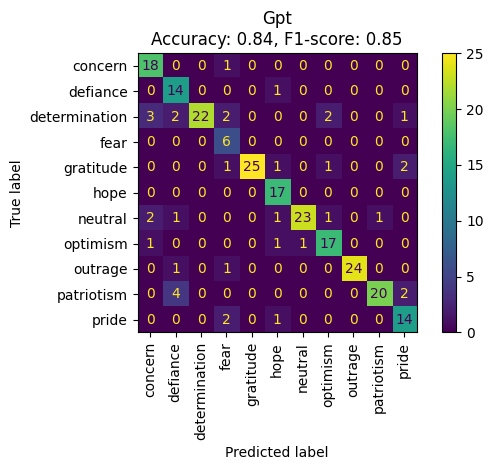

In [ ]:
gpt_cm, gpt_acc, gpt_f1 = confusion_matrix_show(df_val_gpt, 'gpt')

In [ ]:
def common_cm():
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

  # Plot the GPT confusion matrix
  gpt_cm.plot(include_values=True, cmap='viridis', ax=ax1, xticks_rotation='vertical', values_format=None)
  ax1.set_title(f'Confusion Matrix for ZEGS\nAccuracy: {gpt_acc:.2f}, F1-score: {gpt_f1:.2f}')

  # Plot the BERT confusion matrix
  bert_cm.plot(include_values=True, cmap='viridis', ax=ax2, xticks_rotation='vertical', values_format=None)
  ax2.set_title(f'Confusion Matrix for BERT\nAccuracy: {bert_acc:.2f}, F1-score: {bert_f1:.2f}')

  plt.tight_layout()
  plt.savefig('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Images/cm_gpt_bert.png', dpi=300)
  plt.show()

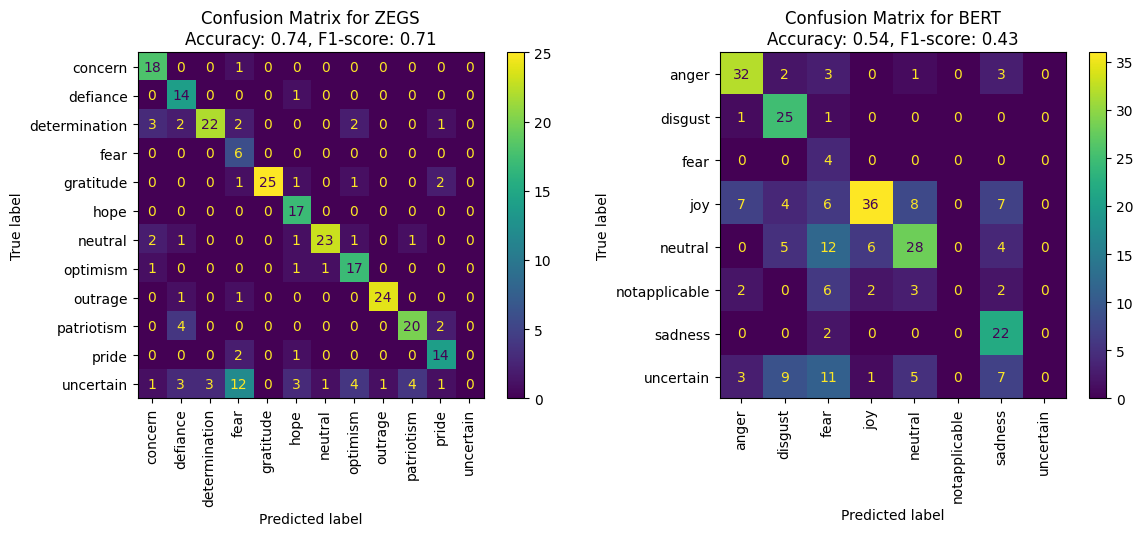

In [ ]:
common_cm()

In [ ]:
df_val_gpt[df_val_gpt['final_label'] == 'uncertain'].shape[0]

33

In [ ]:
total_num = 270

In [ ]:
df_val_gpt[df_val_gpt['Input.suggested_emotion_gpt'] == df_val_gpt['final_label']].shape[0]/270

0.7407407407407407

In [ ]:
33 / 70

0.4714285714285714

In [ ]:

y_true = df_val_gpt['final_label']
y_pred = df_val_gpt[f'Input.suggested_emotion_gpt']

f1_score(y_true, y_pred, labels=np.unique(y_pred), average='micro')

0.7889546351084812

In [ ]:
report = classification_report(y_true, y_pred, output_dict=True, labels=np.unique(y_pred))
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
concern,0.720000,0.947368,0.818182,19.0
defiance,0.560000,0.933333,0.700000,15.0
determination,0.880000,0.687500,0.771930,32.0
fear,0.240000,1.000000,0.387097,6.0
gratitude,1.000000,0.833333,0.909091,30.0
hope,0.680000,1.000000,0.809524,17.0
neutral,0.920000,0.793103,0.851852,29.0
optimism,0.680000,0.850000,0.755556,20.0
outrage,0.960000,0.923077,0.941176,26.0
patriotism,0.800000,0.769231,0.784314,26.0


In [ ]:
# Concern
18 / (18 + 1)
18 / (18 + 7)

0.9473684210526315

In [ ]:
# Fear
6 / (6 + 19)
6 / (6 + 19)

0.24

In [ ]:
import seaborn as sns

def eval_adjust(df):
  '''Eval adjusted given the "uncertain" label. For GPT only.'''

  # copy
  df_grouped = df.copy()

  y_true = df_val_gpt['final_label']
  y_pred = df_val_gpt['Input.suggested_emotion_gpt']


  acc = accuracy_score(y_true, y_pred)
  f1_macro = f1_score(y_true, y_pred, labels=np.unique(y_pred), average='macro')
  f1_weighted = f1_score(y_true, y_pred, labels=np.unique(y_pred), average='weighted')

  # CM
  cm = confusion_matrix(y_true, y_pred)

  # Remove the column corresponding to 'uncertain'
  uncertain_index = list(np.unique(np.concatenate((y_true, y_pred)))).index('uncertain')
  cm_adj = np.delete(cm, uncertain_index, axis=1)

  # Create a new list of labels without 'uncertain' for columns only
  labels_adj_cols = [label for label in np.unique(y_pred) if label != 'uncertain']

  # Keep the original labels for rows
  labels_adj_rows = np.unique(y_true)

  # Convert the matrix to a DataFrame for easier plotting
  df_cm = pd.DataFrame(cm_adj, index=labels_adj_rows, columns=labels_adj_cols)

  # Plot the confusion matrix using Seaborn
  plt.figure(figsize=(10, 8))
  sns.heatmap(df_cm, annot=True, cmap='viridis')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Accuracy: ')
  plt.title(f"Accuracy: {acc:.2f}, F1-score (weighted): {f1_weighted:.2f}, F1-score (macro): {f1_macro:.2f}")
  plt.tight_layout()
  plt.savefig('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Images/confusion_matrix.png', dpi=300, bbox_inches='tight')
  plt.show()

  # Classification Report
  report = classification_report(y_true, y_pred, output_dict=True, labels=np.unique(y_pred))
  report_df = pd.DataFrame(report).transpose()
  report_df

  # To latex and csome changes
  report_df_tex = report_df.to_latex(float_format="%.2f")
  report_df_tex = report_df_tex.replace('\\toprule\n', '\\toprule\\toprule\n')
  report_df_tex = report_df_tex.replace('\\bottomrule\n', '\\bottomrule\\bottomrule\n')
  report_df_tex = report_df_tex.replace('pride         &       0.70 &    0.82 &      0.76 &    17.00 \\\\', 'pride         &       0.70 &    0.82 &      0.76 &    17.00 \\\\\n\\midrule')

  print(report_df_tex)
  with open(f'/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/class_report.tex', 'w') as f:
       f.write(report_df_tex)


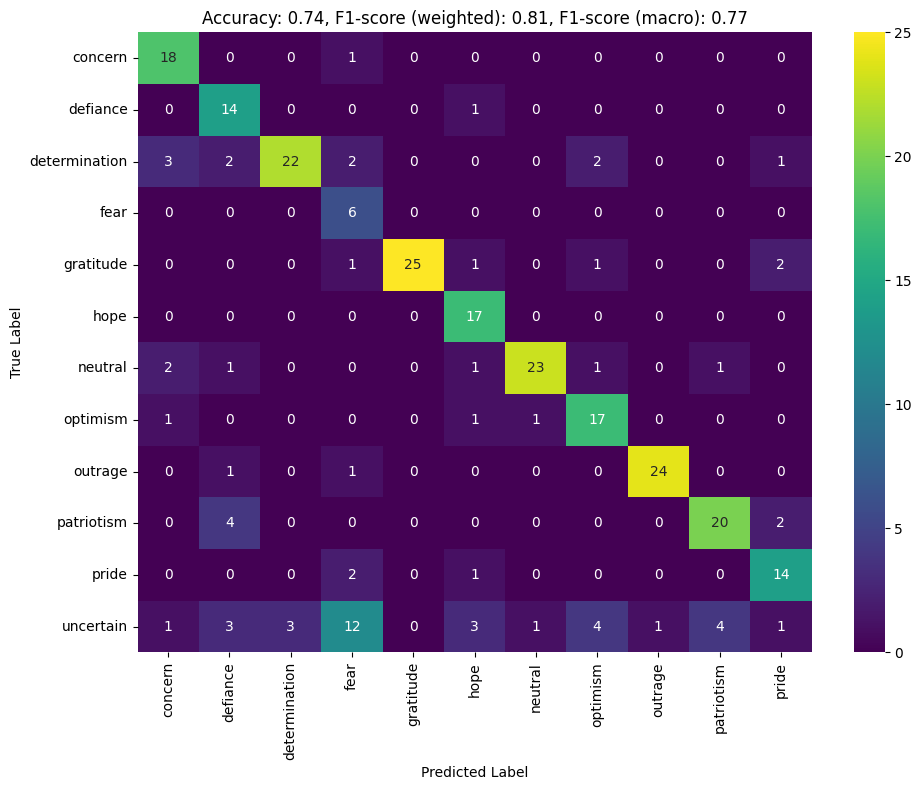

\begin{tabular}{lrrrr}
\toprule\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
concern       &       0.72 &    0.95 &      0.82 &    19.00 \\
defiance      &       0.56 &    0.93 &      0.70 &    15.00 \\
determination &       0.88 &    0.69 &      0.77 &    32.00 \\
fear          &       0.24 &    1.00 &      0.39 &     6.00 \\
gratitude     &       1.00 &    0.83 &      0.91 &    30.00 \\
hope          &       0.68 &    1.00 &      0.81 &    17.00 \\
neutral       &       0.92 &    0.79 &      0.85 &    29.00 \\
optimism      &       0.68 &    0.85 &      0.76 &    20.00 \\
outrage       &       0.96 &    0.92 &      0.94 &    26.00 \\
patriotism    &       0.80 &    0.77 &      0.78 &    26.00 \\
pride         &       0.70 &    0.82 &      0.76 &    17.00 \\
\midrule
micro avg     &       0.74 &    0.84 &      0.79 &   237.00 \\
macro avg     &       0.74 &    0.87 &      0.77 &   237.00 \\
weighted avg  &       0.81 &    0.84 &      0.81 &   237.00 \\
\bottomr

<ipython-input-135-406edda3809c>:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  report_df_tex = report_df.to_latex(float_format="%.2f")


In [ ]:
eval_adjust(df_val_gpt)

In [ ]:
def examples_misclassification(df):
  with pd.option_context("max_colwidth", None):

    df_in = df.copy()
    df_in = df_in[df_in['Input.text_gpt'].str.len() <=500]

    df_in = df_in[df_in['final_label'] == 'uncertain'].reset_index(drop=True)

    df_in['emotion_t3_clean'] = None
    for index, row in df_in.iterrows():
      clean_name = [name.replace('emotion3.', '') for name in row['emotion_t3']]
      clean_name = [row['Input.suggested_emotion_gpt'] if emo == 'notapplicable' else emo for emo in clean_name]
      df_in['emotion_t3_clean'].iloc[index] = tuple(clean_name)

    df_in = df_in[['Input.text_gpt', 'Input.suggested_emotion_gpt', 'emotion_t3_clean']]
    df_in.columns = ['Message', 'ZEGS Label', 'Coder Labels']

    df_out = df_in.sample(10, random_state = 42)
    # Make latex table
    latex_table = df_out.to_latex(index=False, escape=False)
    latex_table = latex_table.replace('\\begin{tabular}{lll}', '\\begin{tabular}{p{8cm}ll}')
    latex_table = latex_table.replace('\\toprule\n', '\\toprule\\toprule\n')
    latex_table = latex_table.replace('_', '')
    latex_table = latex_table.replace('\\\\', '\\\\ \\midrule')

  with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/misclassification_examples.tex', 'w') as file:
      file.write(latex_table)

  print(latex_table)

examples_misclassification(df_val_gpt)

\begin{tabular}{p{8cm}ll}
\toprule\toprule
                                                                                                                                                                                                                                                                                                                                                                                                                                      Message & ZEGS Label &                          Coder Labels \\ \midrule
\midrule
                 This academic year, everyone starts differently. Some are far from home - in other regions of Ukraine. Some are far from home - in other countries. Some are studying remotely, in an online format. Some are in their own school or university, but still not at peace.\n\nHowever, it is important that the academic year begins. It is important that learning continues. And that knowledge about Ukraine does not stop. &   optimism &         

<ipython-input-126-e66152cff38d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in['emotion_t3_clean'].iloc[index] = tuple(clean_name)
<ipython-input-126-e66152cff38d>:20: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_out.to_latex(index=False, escape=False, float_format="%.2f")


In [ ]:
df_val_gpt.columns

Index(['Input.text_gpt', 'agree-t3.yes', 'Input.suggested_emotion_gpt',
       'emotion_t3', 'final_label'],
      dtype='object')

In [ ]:
def fear_check():
  with pd.option_context("max_colwidth", None):
    df_out = df_val_gpt.merge(df_fear_check, how='left', right_on='text_gpt', left_on='Input.text_gpt')[['text_gpt', 'final_label', 'suggested_emotion_gpt', 'emotion_gpt_before_ss']]
    df_out = df_out[df_out['suggested_emotion_gpt'] == 'fear']
    df_out = df_out[df_out['final_label'] == 'uncertain']
    df_out = df_out[['text_gpt', 'final_label', 'emotion_gpt_before_ss']]

    print('Misclassification due to SS: ', df_out[df_out['emotion_gpt_before_ss'] != 'Fear'].shape[0] / df_out.shape[0])
    df_out.columns = ['Message', 'Coders Label', 'GPT-4 Label']

    df_out['Message'] = df_out['Message'].apply(lambda x: '\\tiny ' + x[:500] + '...')

    latex_table = df_out.to_latex(index=False, escape=False)
    latex_table = latex_table.replace('\\begin{tabular}{lll}', '\\begin{tabular}{p{10cm}cc}')
    latex_table = latex_table.replace('\\toprule', '\\toprule\\toprule')
    latex_table = latex_table.replace('\\midrule', '')
    latex_table = latex_table.replace(' \\\\', ' \\\\ \\midrule')
    latex_table = latex_table.replace('\\bottomrule', '\\bottomrule\\bottomrule')
    latex_table = latex_table.replace('_', '')

  with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Tables/emotion_fear_check.tex', 'w') as file:
      file.write(latex_table)
  print(latex_table)

fear_check()

Misclassification due to SS:  0.5833333333333334
\begin{tabular}{p{10cm}cc}
\toprule\toprule
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Message & Coders Label & GPT-4 Label \\ \midrule

 \tiny \n\n37 years ago, the Chornobyl NPP accident left a huge scar on the whole world. The radiation leak turned a once cozy and developed area into an exclusion zone. Today, the 30-kilometer zone around the Chornobyl nuclear power plant remains a dangerous place with a high concentration of radiation. \n\nLast year, the occupier not only seized 

<ipython-input-174-17e102311ba3>:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_out.to_latex(index=False, escape=False)
